In [22]:
# Imports cell with respect to the pytorch library.
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [23]:
# CNN Model Definition and architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
# Data Transforms and Loading
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5375, 0.4891, 0.4224], std=[0.1923, 0.1820, 0.1725])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5375, 0.4891, 0.4224], std=[0.1923, 0.1820, 0.1725])
])

dataset_root = r"C:\Users\yozev\OneDrive\Desktop\artFiltered"
full_dataset = ImageFolder(root=dataset_root, transform=transform_train)

In [25]:
# Dataset Splitting
batch_size = 32
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

dataset_size = len(full_dataset)
train_size = int(0.75 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Model Initialization and Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(full_dataset.classes), dropout=0.4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [26]:
# Training Loop
epochs = 50
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{epochs}]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        val_loop = tqdm(val_loader, desc="Validation")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_loop.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

Validation: 100%|██████████| 304/304 [00:11<00:00, 27.26it/s, loss=2.38]  


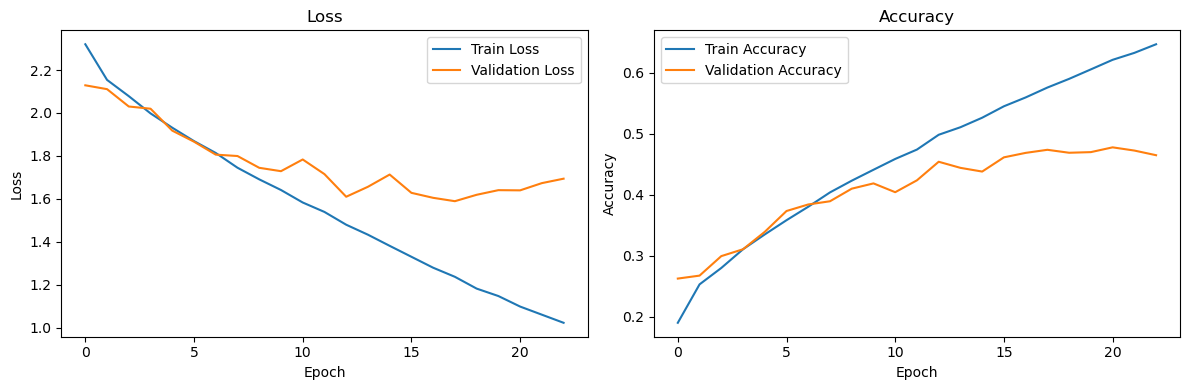

In [27]:
# Plots of the training part.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Model Testing with the best model that we received in the training process
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_predictions)
recall_per_class = recall_score(all_labels, all_predictions, average=None)
precision_per_class = precision_score(all_labels, all_predictions, average=None)
macro_recall = recall_score(all_labels, all_predictions, average='macro')
macro_precision = precision_score(all_labels, all_predictions, average='macro')

C:\Users\yozev\AppData\Local\Temp\ipykernel_10972\857053728.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


In [31]:
# rint Final Metrics
print(f"Test Set Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro-Recall: {macro_recall:.4f}")
print(f"Macro-Precision: {macro_precision:.4f}")
for i, class_name in enumerate(full_dataset.classes):
    print(f"\nClass {class_name}:")
    print(f"Recall: {recall_per_class[i]:.4f}")
    print(f"Precision: {precision_per_class[i]:.4f}")

Test Set Results:
Accuracy: 0.4739
Macro-Recall: 0.4764
Macro-Precision: 0.4766

Class Abstract_Expressionism:
Recall: 0.7163
Precision: 0.5337

Class Art_Nouveau_Modern:
Recall: 0.2996
Precision: 0.5580

Class Baroque:
Recall: 0.5720
Precision: 0.5451

Class Cubism:
Recall: 0.6977
Precision: 0.5272

Class Expressionism:
Recall: 0.2432
Precision: 0.2778

Class Impressionism:
Recall: 0.4274
Precision: 0.4435

Class Naive_Art_Primitivism:
Recall: 0.3969
Precision: 0.5000

Class Northern_Renaissance:
Recall: 0.7269
Precision: 0.5231

Class Post_Impressionism:
Recall: 0.3280
Precision: 0.3872

Class Realism:
Recall: 0.4652
Precision: 0.3503

Class Rococo:
Recall: 0.6021
Precision: 0.6506

Class Romanticism:
Recall: 0.3379
Precision: 0.5309

Class Symbolism:
Recall: 0.3802
Precision: 0.3687


In [30]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report as a dictionary
report_dict = classification_report(all_labels, all_predictions, target_names=full_dataset.classes, zero_division=0, output_dict=True)

# Convert the classification report dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Display the classification report as a table
print("Classification Report:")
print(report_df)

Classification Report:
                        precision    recall  f1-score      support
Abstract_Expressionism   0.533733  0.716298  0.611684   497.000000
Art_Nouveau_Modern       0.557971  0.299611  0.389873   514.000000
Baroque                  0.545113  0.571992  0.558229   507.000000
Cubism                   0.527157  0.697674  0.600546   473.000000
Expressionism            0.277778  0.243191  0.259336   514.000000
Impressionism            0.443515  0.427419  0.435318   496.000000
Naive_Art_Primitivism    0.500000  0.396887  0.442516   514.000000
Northern_Renaissance     0.523121  0.726908  0.608403   498.000000
Post_Impressionism       0.387173  0.327968  0.355120   497.000000
Realism                  0.350299  0.465209  0.399658   503.000000
Rococo                   0.650575  0.602128  0.625414   470.000000
Romanticism              0.530864  0.337917  0.412965   509.000000
Symbolism                0.368737  0.380165  0.374364   484.000000
accuracy                 0.473904  0.47